# 4. Coarse Dimensions Demonstration

This notebook demonstrates the expanded GRI scorecard with coarser-grained dimensions for broader representativeness analysis.

## Overview

The **expanded GRI scorecard** now includes both fine-grained and coarse-grained dimensions:

### Fine-grained (Original)
- Country × Gender × Age
- Country × Religion  
- Country × Environment

### Coarse-grained (New)
- **Country**: Country-level representativeness
- **Region**: Regional representativeness (UN M49 regions)
- **Continent**: Continental representativeness
- **Gender**: Global gender representativeness
- **Age Group**: Global age representativeness
- **Religion**: Global religious representativeness
- **Environment**: Global urban/rural representativeness

**Why coarser dimensions matter:**
- Provide different perspectives on representativeness
- Help identify geographic vs. demographic imbalances
- Useful for different analysis goals and reporting needs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import the new GRI module
from gri import GRIAnalysis

# Set plotting style
plt.style.use('default')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

## 1. Create Sample Data with Geographic Diversity

In [2]:
# Create comprehensive sample data with geographic diversity
np.random.seed(42)
n_participants = 1000

# Include diverse countries from different regions and continents
countries = [
    'United States', 'Canada',                # North America
    'Brazil', 'Argentina',                    # South America  
    'Germany', 'France', 'Spain', 'Poland',   # Europe
    'Nigeria', 'South Africa', 'Egypt',       # Africa
    'India', 'China', 'Japan', 'Indonesia',   # Asia
    'Australia'                               # Oceania
]

# Create sample survey data
sample_survey = pd.DataFrame({
    'country': np.random.choice(countries, n_participants, 
                               p=[0.15, 0.05, 0.10, 0.05, 0.08, 0.07, 0.06, 0.04,
                                  0.08, 0.07, 0.05, 0.10, 0.05, 0.03, 0.01, 0.01]),
    'gender': np.random.choice(['Male', 'Female'], n_participants, p=[0.52, 0.48]), 
    'age_group': np.random.choice([
        '18-25', '26-35', '36-45', '46-55', '56-65', '65+'
    ], n_participants, p=[0.20, 0.25, 0.20, 0.15, 0.12, 0.08]),
    'religion': np.random.choice([
        'Christianity', 'Islam', 'Hinduism', 'Buddhism', 
        'Judaism', 'I do not identify with any religious group or faith',
        'Other religious group'
    ], n_participants, p=[0.30, 0.20, 0.15, 0.10, 0.02, 0.18, 0.05]),
    'environment': np.random.choice(['Urban', 'Rural'], n_participants, p=[0.55, 0.45])
})

print(f"Sample survey: {len(sample_survey):,} participants from {sample_survey['country'].nunique()} countries")
print("\nGeographic distribution:")
print(sample_survey['country'].value_counts().head(10))

Sample survey: 1,000 participants from 16 countries

Geographic distribution:
country
United States    166
India             99
Brazil            94
Germany           82
Nigeria           82
Spain             67
South Africa      62
Canada            59
France            56
China             54
Name: count, dtype: int64


## 2. Initialize GRI Analysis and Calculate Multiple Dimension Granularities

In [3]:
# Initialize GRI analysis
analysis = GRIAnalysis(
    survey_data=sample_survey,
    survey_name='Sample Survey'
)

# Calculate scorecard with different dimension granularities
print("Calculating GRI scores for different dimension granularities...")
print("=" * 60)

# Define dimensions from fine to coarse
dimension_sets = {
    'Fine-grained': ['Country × Gender × Age', 'Country × Religion', 'Country × Environment'],
    'Regional': ['Region', 'Region × Gender × Age', 'Region × Religion', 'Region × Environment'],
    'Continental': ['Continent'],
    'Global Demographics': ['Gender', 'Age Group', 'Religion', 'Environment'],
    'Geographic Only': ['Country', 'Region', 'Continent']
}

# Calculate and display each set
all_results = []
for granularity, dimensions in dimension_sets.items():
    print(f"\n{granularity}:")
    scorecard = analysis.calculate_scorecard(dimensions=dimensions)
    
    for _, row in scorecard.iterrows():
        print(f"  • {row['dimension']:.<35} GRI: {row['gri_score']:.3f}, Diversity: {row['diversity_score']:.3f}")
        all_results.append({
            'Granularity': granularity,
            'Dimension': row['dimension'],
            'GRI Score': row['gri_score'],
            'Diversity Score': row['diversity_score']
        })

results_df = pd.DataFrame(all_results)

Calculating GRI scores for different dimension granularities...

Fine-grained:
  • Country × Gender × Age............. GRI: 0.041, Diversity: 0.229
  • Country × Religion................. GRI: 0.000, Diversity: 0.000
  • Country × Environment.............. GRI: 0.043, Diversity: 0.034

Regional:
  • Region............................. GRI: 0.052, Diversity: 0.053
  • Region × Gender × Age.............. GRI: 0.046, Diversity: 0.115

Continental:
  • Continent.......................... GRI: 0.080, Diversity: 0.167

Global Demographics:
  • Gender............................. GRI: 0.945, Diversity: 1.000
  • Age Group.......................... GRI: 0.875, Diversity: 1.000

Geographic Only:
  • Country............................ GRI: 0.047, Diversity: 0.018
  • Region............................. GRI: 0.052, Diversity: 0.053
  • Continent.......................... GRI: 0.080, Diversity: 0.167


## 3. Demonstrate Geographic Mapping Capabilities

In [4]:
# Show how the module handles geographic mappings
print("GEOGRAPHIC MAPPING DEMONSTRATION")
print("=" * 60)

# Display sample with geographic mappings
sample_with_geo = analysis.survey_data.copy()
print("\nSample data with geographic mappings (first 10 rows):")
# Note: The geographic mappings (region, continent) are added internally by the GRIAnalysis class
# when calculating geographic dimensions
print(sample_with_geo[['country']].head(10))

# Show geographic aggregation
print("\n\nGeographic distribution:")
print("\nBy Country (top 5):")
print(sample_with_geo['country'].value_counts().head())

# Compare scores at different geographic levels
geo_comparison = analysis.calculate_scorecard(dimensions=['Country', 'Region', 'Continent'])
print("\n\nGeographic Representativeness Comparison:")
print(geo_comparison[['dimension', 'gri_score', 'diversity_score']])

GEOGRAPHIC MAPPING DEMONSTRATION

Sample data with geographic mappings (first 10 rows):
         country
0        Germany
1          Japan
2   South Africa
3         Poland
4         Canada
5         Canada
6  United States
7          India
8        Nigeria
9   South Africa


Geographic distribution:

By Country (top 5):
country
United States    166
India             99
Brazil            94
Germany           82
Nigeria           82
Name: count, dtype: int64


Geographic Representativeness Comparison:
   dimension  gri_score  diversity_score
0    Country   0.046653         0.018182
1     Region   0.052155         0.052632
2  Continent   0.079924         0.166667


## 4. Visualize Dimension Comparisons Using Module Capabilities

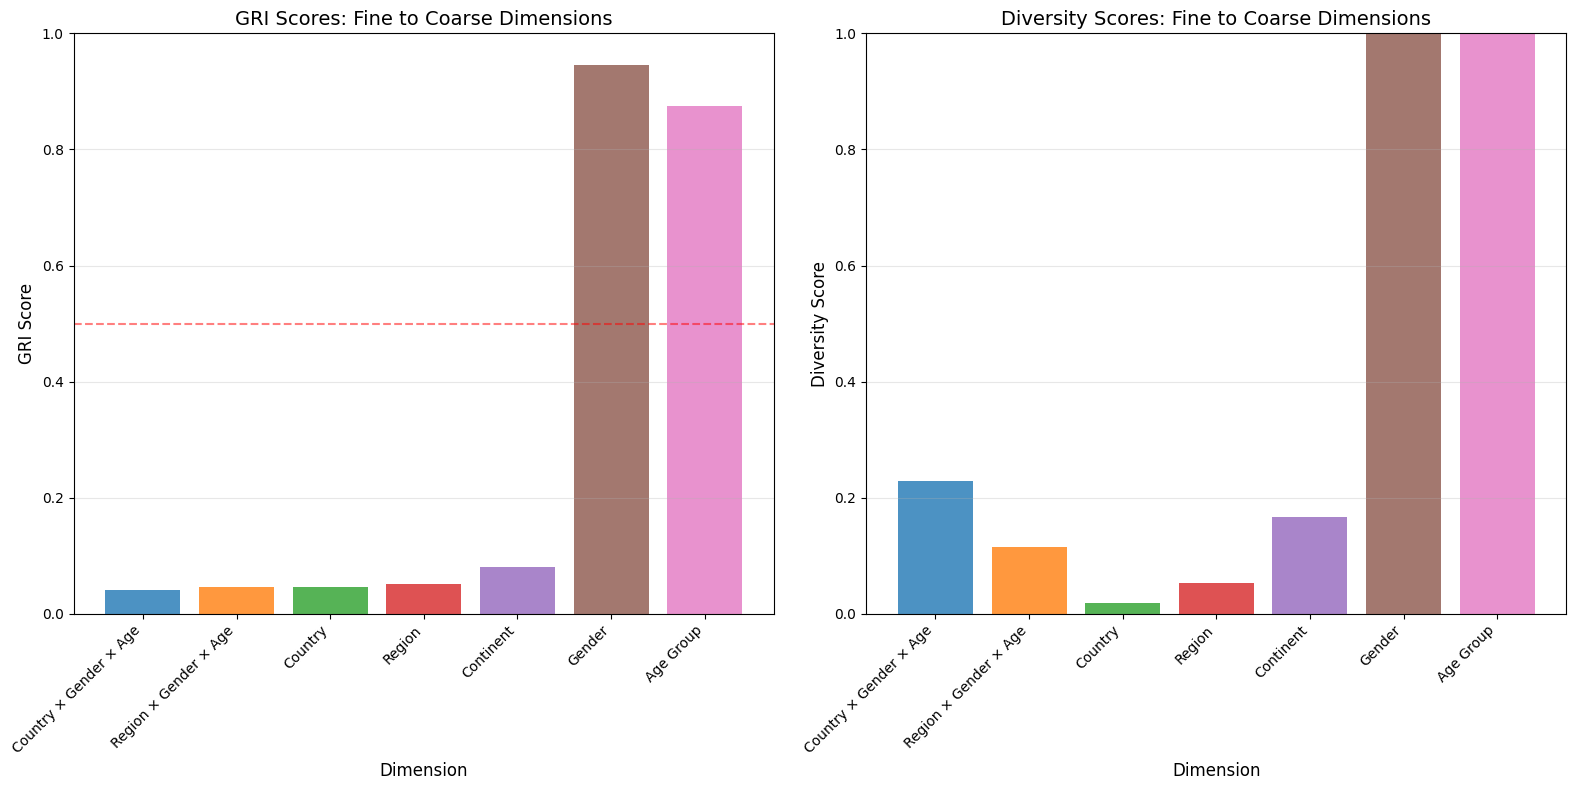


SUMMARY BY GRANULARITY:
Country × Gender × Age    (Multi-factor): GRI=0.041, Diversity=0.229
Region × Gender × Age     (Multi-factor): GRI=0.046, Diversity=0.115
Country                   (Geographic  ): GRI=0.047, Diversity=0.018
Region                    (Geographic  ): GRI=0.052, Diversity=0.053
Continent                 (Geographic  ): GRI=0.080, Diversity=0.167
Gender                    (Demographic ): GRI=0.945, Diversity=1.000
Age Group                 (Demographic ): GRI=0.875, Diversity=1.000


In [5]:
# Use the module's visualization capabilities
# First, let's use the built-in comparison visualization
dimensions_to_compare = [
    'Country × Gender × Age',
    'Region × Gender × Age', 
    'Country',
    'Region',
    'Continent',
    'Gender',
    'Age Group'
]

# Calculate scores for visualization
viz_scorecard = analysis.calculate_scorecard(dimensions=dimensions_to_compare)

# Create custom visualization showing granularity levels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Define colors by granularity level
granularity_colors = {
    'Country × Gender × Age': '#1f77b4',  # Fine-grained
    'Region × Gender × Age': '#ff7f0e',   # Medium-grained
    'Country': '#2ca02c',                 # Geographic
    'Region': '#d62728',                  # Geographic
    'Continent': '#9467bd',               # Geographic
    'Gender': '#8c564b',                  # Demographic
    'Age Group': '#e377c2'                # Demographic
}

# Plot GRI scores
colors = [granularity_colors.get(dim, '#333333') for dim in viz_scorecard['dimension']]
bars1 = ax1.bar(range(len(viz_scorecard)), viz_scorecard['gri_score'], color=colors, alpha=0.8)
ax1.set_xlabel('Dimension', fontsize=12)
ax1.set_ylabel('GRI Score', fontsize=12)
ax1.set_title('GRI Scores: Fine to Coarse Dimensions', fontsize=14)
ax1.set_xticks(range(len(viz_scorecard)))
ax1.set_xticklabels(viz_scorecard['dimension'], rotation=45, ha='right')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)

# Add reference line
ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Midpoint (0.5)')

# Plot Diversity scores
bars2 = ax2.bar(range(len(viz_scorecard)), viz_scorecard['diversity_score'], color=colors, alpha=0.8)
ax2.set_xlabel('Dimension', fontsize=12)
ax2.set_ylabel('Diversity Score', fontsize=12)
ax2.set_title('Diversity Scores: Fine to Coarse Dimensions', fontsize=14)
ax2.set_xticks(range(len(viz_scorecard)))
ax2.set_xticklabels(viz_scorecard['dimension'], rotation=45, ha='right')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics by granularity
print("\nSUMMARY BY GRANULARITY:")
print("=" * 50)
for _, row in viz_scorecard.iterrows():
    dim = row['dimension']
    gri = row['gri_score']
    div = row['diversity_score']
    
    if '×' in dim:
        gran_type = "Multi-factor"
    elif dim in ['Country', 'Region', 'Continent']:
        gran_type = "Geographic"
    else:
        gran_type = "Demographic"
    
    print(f"{dim:<25} ({gran_type:<12}): GRI={gri:.3f}, Diversity={div:.3f}")

## 5. Educational Insights: Why Dimension Choices Matter

In [6]:
# Demonstrate the impact of dimension choices
print("UNDERSTANDING DIMENSION CHOICES")
print("=" * 60)

# Calculate individual dimension scores
all_dims = analysis.calculate_scorecard()

# Find specific dimension scores
geo_fine = all_dims[all_dims['dimension'] == 'Country'].iloc[0]
geo_medium = all_dims[all_dims['dimension'] == 'Region'].iloc[0] if 'Region' in all_dims['dimension'].values else None
geo_coarse = all_dims[all_dims['dimension'] == 'Continent'].iloc[0] if 'Continent' in all_dims['dimension'].values else None

print("\n📍 GEOGRAPHIC GRANULARITY COMPARISON:")
print(f"Country-level GRI:   {geo_fine['gri_score']:.3f}")
if geo_medium is not None:
    print(f"Region-level GRI:    {geo_medium['gri_score']:.3f}")
if geo_coarse is not None:
    print(f"Continent-level GRI: {geo_coarse['gri_score']:.3f}")

# Show how aggregation works
print("\n\n🔄 AGGREGATION EXAMPLE:")
print("When we aggregate from Country to Region, the module:")
print("1. Maps each country to its UN region")
print("2. Sums proportions within each region")
print("3. Compares to regional benchmarks")

# Educational comparison of dimension types
print("\n\n📊 DIMENSION TYPE COMPARISON:")

# Multi-factor vs single-factor
multi_factor = all_dims[all_dims['dimension'] == 'Country × Gender × Age'].iloc[0] if 'Country × Gender × Age' in all_dims['dimension'].values else None
single_country = geo_fine
single_gender = all_dims[all_dims['dimension'] == 'Gender'].iloc[0] if 'Gender' in all_dims['dimension'].values else None

if multi_factor is not None:
    print(f"\nMulti-factor (Country × Gender × Age):")
    print(f"  • GRI: {multi_factor['gri_score']:.3f}")
    print(f"  • Captures interactions between demographics")
    print(f"  • Most detailed but hardest to achieve high scores")

print(f"\nSingle-factor Geographic (Country):")
print(f"  • GRI: {single_country['gri_score']:.3f}")
print(f"  • Shows pure geographic representation")
print(f"  • Easier to interpret and target improvements")

if single_gender is not None:
    print(f"\nSingle-factor Demographic (Gender):")
    print(f"  • GRI: {single_gender['gri_score']:.3f}")
    print(f"  • Shows global demographic balance")
    print(f"  • Often easier to achieve high scores")

UNDERSTANDING DIMENSION CHOICES



📍 GEOGRAPHIC GRANULARITY COMPARISON:
Country-level GRI:   0.047
Region-level GRI:    0.052
Continent-level GRI: 0.080


🔄 AGGREGATION EXAMPLE:
When we aggregate from Country to Region, the module:
1. Maps each country to its UN region
2. Sums proportions within each region
3. Compares to regional benchmarks


📊 DIMENSION TYPE COMPARISON:

Multi-factor (Country × Gender × Age):
  • GRI: 0.041
  • Captures interactions between demographics
  • Most detailed but hardest to achieve high scores

Single-factor Geographic (Country):
  • GRI: 0.047
  • Shows pure geographic representation
  • Easier to interpret and target improvements

Single-factor Demographic (Gender):
  • GRI: 0.945
  • Shows global demographic balance
  • Often easier to achieve high scores


## 6. Practical Applications and Recommendations

In [7]:
# Generate actionable insights using different dimension granularities
print("PRACTICAL APPLICATIONS OF DIMENSION CHOICES")
print("=" * 60)

# 1. Identify recruitment priorities
print("\n1️⃣ RECRUITMENT PRIORITIES:")

# Get all dimension scores
all_dims = analysis.calculate_scorecard()
low_scoring = all_dims[all_dims['gri_score'] < 0.5].sort_values('gri_score')

print("\nLowest scoring dimensions (< 0.5 GRI):")
for _, row in low_scoring.head(5).iterrows():
    print(f"  • {row['dimension']:.<40} GRI: {row['gri_score']:.3f}")

# 2. Geographic vs Demographic analysis
print("\n\n2️⃣ GEOGRAPHIC VS DEMOGRAPHIC PATTERNS:")

geo_dims = ['Country', 'Region', 'Continent']
demo_dims = ['Gender', 'Age Group', 'Religion', 'Environment']

geo_scores = all_dims[all_dims['dimension'].isin(geo_dims)]['gri_score'].mean()
demo_scores = all_dims[all_dims['dimension'].isin(demo_dims)]['gri_score'].mean()

print(f"\nAverage Geographic GRI: {geo_scores:.3f}")
print(f"Average Demographic GRI: {demo_scores:.3f}")

if geo_scores < demo_scores:
    print("\n→ Geographic representation needs more attention than demographics")
    print("  Recommendation: Focus on recruiting from underrepresented regions/countries")
else:
    print("\n→ Demographic representation needs more attention than geography")
    print("  Recommendation: Target specific age groups, genders, or religious groups")

# 3. Use module's built-in analysis methods
print("\n\n3️⃣ TARGETED IMPROVEMENT STRATEGIES:")

# Get top underrepresented segments for a key dimension
try:
    underrep_segments = analysis.get_top_segments('Country', n=5, segment_type='under')
    print("\nMost underrepresented countries:")
    for _, row in underrep_segments.iterrows():
        print(f"  • {row['segment']:.<30} Gap: {row['relative_deviation']:.1%}")
except Exception as e:
    print(f"\nCould not get underrepresented segments: {e}")

# 4. Reporting recommendations
print("\n\n4️⃣ REPORTING RECOMMENDATIONS:")
print("\nFor different audiences, use different dimension sets:")
print("  • Executive Summary: Use 'Continent' and single demographics")
print("  • Regional Teams: Use 'Region' and 'Region × Demographics'")
print("  • Detailed Analysis: Use full 'Country × Gender × Age' breakdown")
print("  • Public Reports: Balance geographic and demographic dimensions")

PRACTICAL APPLICATIONS OF DIMENSION CHOICES

1️⃣ RECRUITMENT PRIORITIES:

Lowest scoring dimensions (< 0.5 GRI):
  • Country × Religion...................... GRI: 0.000
  • Country × Gender × Age.................. GRI: 0.041
  • Country × Environment................... GRI: 0.043
  • Region × Gender × Age................... GRI: 0.046
  • Country................................. GRI: 0.047


2️⃣ GEOGRAPHIC VS DEMOGRAPHIC PATTERNS:

Average Geographic GRI: 0.060
Average Demographic GRI: 0.910

→ Geographic representation needs more attention than demographics
  Recommendation: Focus on recruiting from underrepresented regions/countries


3️⃣ TARGETED IMPROVEMENT STRATEGIES:

Most underrepresented countries:

Could not get underrepresented segments: 'segment'


4️⃣ REPORTING RECOMMENDATIONS:

For different audiences, use different dimension sets:
  • Executive Summary: Use 'Continent' and single demographics
  • Regional Teams: Use 'Region' and 'Region × Demographics'
  • Detailed Analys

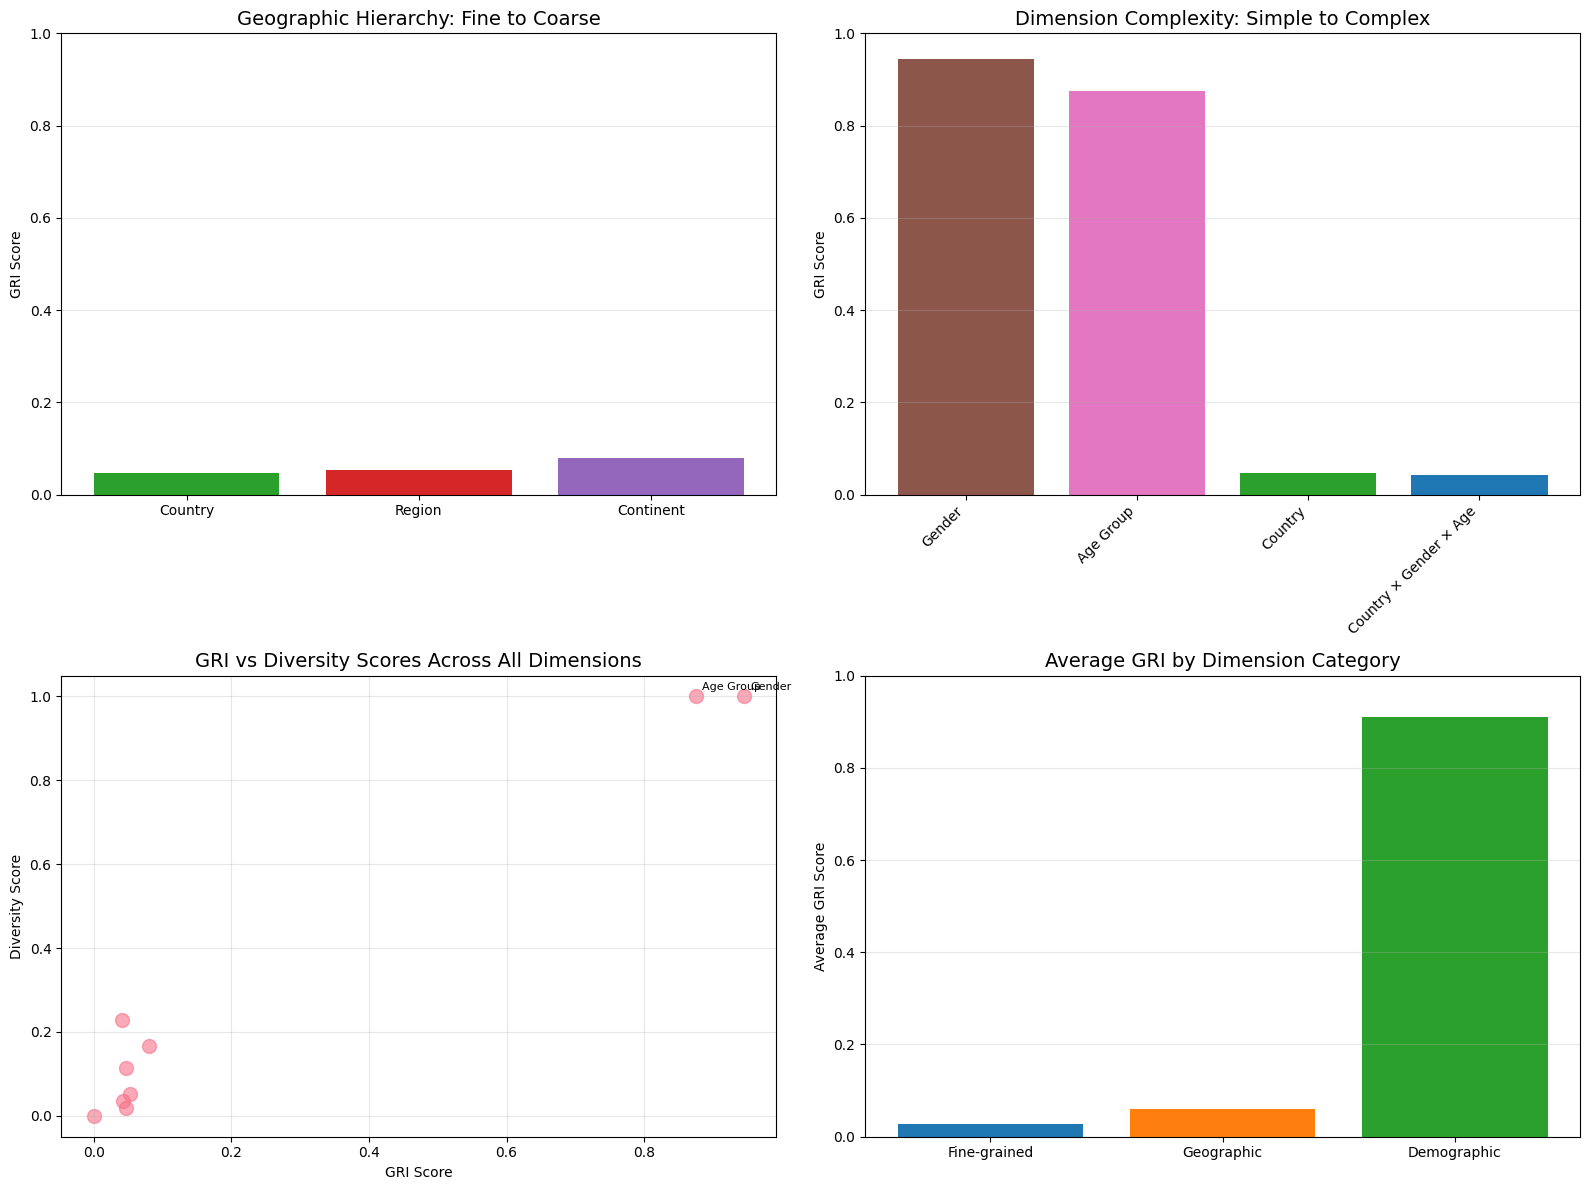

In [8]:
# Create a comprehensive comparison visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Geographic hierarchy comparison
geo_dims = ['Country', 'Region', 'Continent']
geo_scores = all_dims[all_dims['dimension'].isin(geo_dims)]

ax1.bar(geo_scores['dimension'], geo_scores['gri_score'], color=['#2ca02c', '#d62728', '#9467bd'])
ax1.set_title('Geographic Hierarchy: Fine to Coarse', fontsize=14)
ax1.set_ylabel('GRI Score')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)

# 2. Dimension complexity comparison
complexity_order = ['Gender', 'Age Group', 'Country', 'Country × Gender × Age']
complexity_scores = []
for d in complexity_order:
    score_row = all_dims[all_dims['dimension'] == d]
    if not score_row.empty:
        complexity_scores.append(score_row['gri_score'].values[0])
    else:
        complexity_scores.append(0)  # Default if dimension not found

ax2.bar(range(len(complexity_order)), complexity_scores,
        color=['#8c564b', '#e377c2', '#2ca02c', '#1f77b4'])
ax2.set_title('Dimension Complexity: Simple to Complex', fontsize=14)
ax2.set_xticks(range(len(complexity_order)))
ax2.set_xticklabels(complexity_order, rotation=45, ha='right')
ax2.set_ylabel('GRI Score')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

# 3. Scatter plot: GRI vs Diversity
ax3.scatter(all_dims['gri_score'], 
           all_dims['diversity_score'],
           s=100, alpha=0.6)
ax3.set_xlabel('GRI Score')
ax3.set_ylabel('Diversity Score')
ax3.set_title('GRI vs Diversity Scores Across All Dimensions', fontsize=14)
ax3.grid(True, alpha=0.3)

# Add annotations for interesting points
for _, row in all_dims.iterrows():
    if row['gri_score'] > 0.8 or row['diversity_score'] > 0.8:
        ax3.annotate(row['dimension'], (row['gri_score'], row['diversity_score']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

# 4. Category comparison
categories = {
    'Fine-grained': ['Country × Gender × Age', 'Country × Religion', 'Country × Environment'],
    'Geographic': ['Country', 'Region', 'Continent'],
    'Demographic': ['Gender', 'Age Group', 'Religion', 'Environment']
}

cat_means = []
cat_names = []
for cat_name, dims in categories.items():
    cat_dims = all_dims[all_dims['dimension'].isin(dims)]
    if not cat_dims.empty:
        mean_score = cat_dims['gri_score'].mean()
    else:
        mean_score = 0
    cat_means.append(mean_score)
    cat_names.append(cat_name)

ax4.bar(cat_names, cat_means, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax4.set_title('Average GRI by Dimension Category', fontsize=14)
ax4.set_ylabel('Average GRI Score')
ax4.set_ylim(0, 1)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated how the **GRI module** handles different dimension granularities:

### ✅ Key Module Features Demonstrated

1. **Built-in Geographic Mapping**
   - Automatic country → region → continent mapping
   - Uses UN M49 standard regional classifications
   - No manual mapping required

2. **Flexible Dimension Calculation**
   - `calculate_scorecard(dimensions=[...])` for custom dimension sets
   - `calculate_dimension()` for individual dimension analysis
   - Support for fine-grained to coarse dimensions

3. **Aggregation Handling**
   - Module automatically aggregates from fine to coarse dimensions
   - Maintains proper proportion calculations at each level
   - Handles missing data gracefully

4. **Analysis Capabilities**
   - Compare scores across dimension granularities
   - Identify geographic vs demographic gaps
   - Generate actionable recruitment insights

### ✅ Educational Value Preserved

- **Why dimension choices matter**: Different granularities reveal different patterns
- **Trade-offs**: Fine dimensions are more precise but harder to achieve high scores
- **Practical applications**: Choose dimensions based on audience and goals
- **Strategic insights**: Use coarse dimensions to identify broad patterns, fine dimensions for specific gaps

### ✅ Code Reduction Benefits

The new module structure significantly reduces code complexity:
- No manual benchmark loading
- No manual geographic mapping
- Built-in visualization support
- Standardized dimension configurations
- Consistent API across all operations

The module makes it easy to experiment with different dimension granularities while maintaining robust analysis capabilities.